In [1]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

from matplotlib.patches import PathPatch
from matplotlib.path import Path

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed']
L_markers = ['s', '^', 'v', 'd', 'P']

In [2]:
# closure test? i.e. there is truth pythia data somewhere to compare to
closure = True

# define binnings
n_bins = 9 # WARNING RooUnfold seg faults if too many bins used
binning = np.linspace(20,40,10)
bincenters = get_lin_bincenters(binning)
binwidths = get_binwidths(binning)

labels = "jet $p_T$"

n_iter = 8

In [3]:
len(binning)

10

In [4]:
# file defs, hist imports

f_unfolded = ur.open("./unfolded_closure_new.root")
f_preunfold = ur.open("./preunfold_closure_new.root")

# Data, reco [theta_unknown_S]
h3_raw = f_preunfold["raw"]
h1_raw = f_preunfold["raw1D"]

# MC, reco [theta0_S]
h3_reco = f_preunfold["reco"]
h1_reco = f_preunfold["reco1D"]

# MC, true [theta0_G]
h3_gen = f_preunfold["gen"]
h1_gen = f_preunfold["gen1D"]

# Data, true [theta_unknown_G]
if closure:
    h3_true = f_preunfold["true"]
    h1_true = f_preunfold["true1D"]

h3_unfolded = []
for i in range(1,n_iter+1):
    h3_unfolded.append(f_unfolded["Baysian_Unfoldediter{}".format(i)])

h1_unfolded = []
for i in range(1,n_iter+1):
    h1_unfolded.append(f_unfolded["Baysian_Unfolded1Diter{}".format(i)])


In [5]:
proj = lambda a : a.values()
proj_err = lambda a : a.errors()

theta0_G = proj(h1_gen)
theta0_S = proj(h1_reco)
theta_unknown_G = proj(h1_true)
theta_unknown_S = proj(h1_raw)

theta_unfolded = [proj(a) for a in h1_unfolded]

theta0_G_err = proj_err(h1_gen)
theta0_S_err = proj_err(h1_reco)
theta_unknown_G_err = proj_err(h1_true)
theta_unknown_S_err = proj_err(h1_raw)

theta_unfolded_err = [proj_err(a) for a in h1_unfolded]


[3742. 5789. 6102. 5750. 4862. 4004. 3141. 2478. 1954.]
(9,)
[20.         22.22222222 24.44444444 26.66666667 28.88888889 31.11111111
 33.33333333 35.55555556 37.77777778 40.        ]
10
(array([3742., 5789., 6102., 5750., 4862., 4004., 3141., 2478., 1954.]), array([20.        , 22.22222222, 24.44444444, 26.66666667, 28.88888889,
       31.11111111, 33.33333333, 35.55555556, 37.77777778, 40.        ]), <BarContainer object of 9 artists>)
9
9


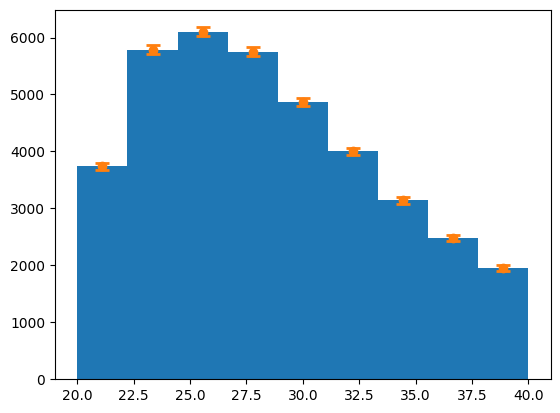

In [6]:
print(theta0_G)
print(theta0_G.shape)
print(binning)
print(len(binning))

print(plt.hist(binning[:-1], binning, weights=theta0_G))
print(len(binning[:-1]))
print(len(theta0_G_err))
plt.errorbar(bincenters, theta0_G, yerr=theta0_G_err, capsize=5, capthick=2, fmt='o', linestyle="None")
plt.show()

In [7]:
for iteration in range(n_iter):
    print(theta_unfolded[iteration])
    print(theta_unfolded_err[iteration])

[3923.95203842 6035.83727949 6411.43929875 6028.43919633 5063.70938865
 4118.44666039 3208.36185854 2492.8212606  1929.99301884]
[35.30341078 41.91715372 39.85833021 36.89287784 31.70045011 28.25725785
 24.55518137 22.20714001 22.89070963]
[3938.60580291 6029.22211805 6460.35893891 6074.43412413 5085.49270643
 4103.68394592 3190.77709946 2454.37493394 1876.05033026]
[52.12493049 55.41941267 51.66783305 48.7811279  42.34826661 38.61840005
 34.11840269 31.42018847 34.81703088]
[3942.8049011  6007.10478798 6491.60540525 6107.35028207 5103.79927546
 4095.52795859 3187.06138035 2434.33390231 1843.41210689]
[64.98208881 66.37593368 63.05495507 60.72627648 52.817454   47.97346809
 42.08054427 38.25017236 43.54873311]
[3944.36504091 5980.20807666 6513.92192376 6131.63332788 5118.268469
 4089.17023692 3189.56004405 2423.57425425 1822.29862658]
[75.20170576 75.9125863  73.7219199  71.74226575 62.42970874 56.38219026
 49.18409029 43.93790084 50.37680196]
[3946.14313187 5952.894402   6531.52104481

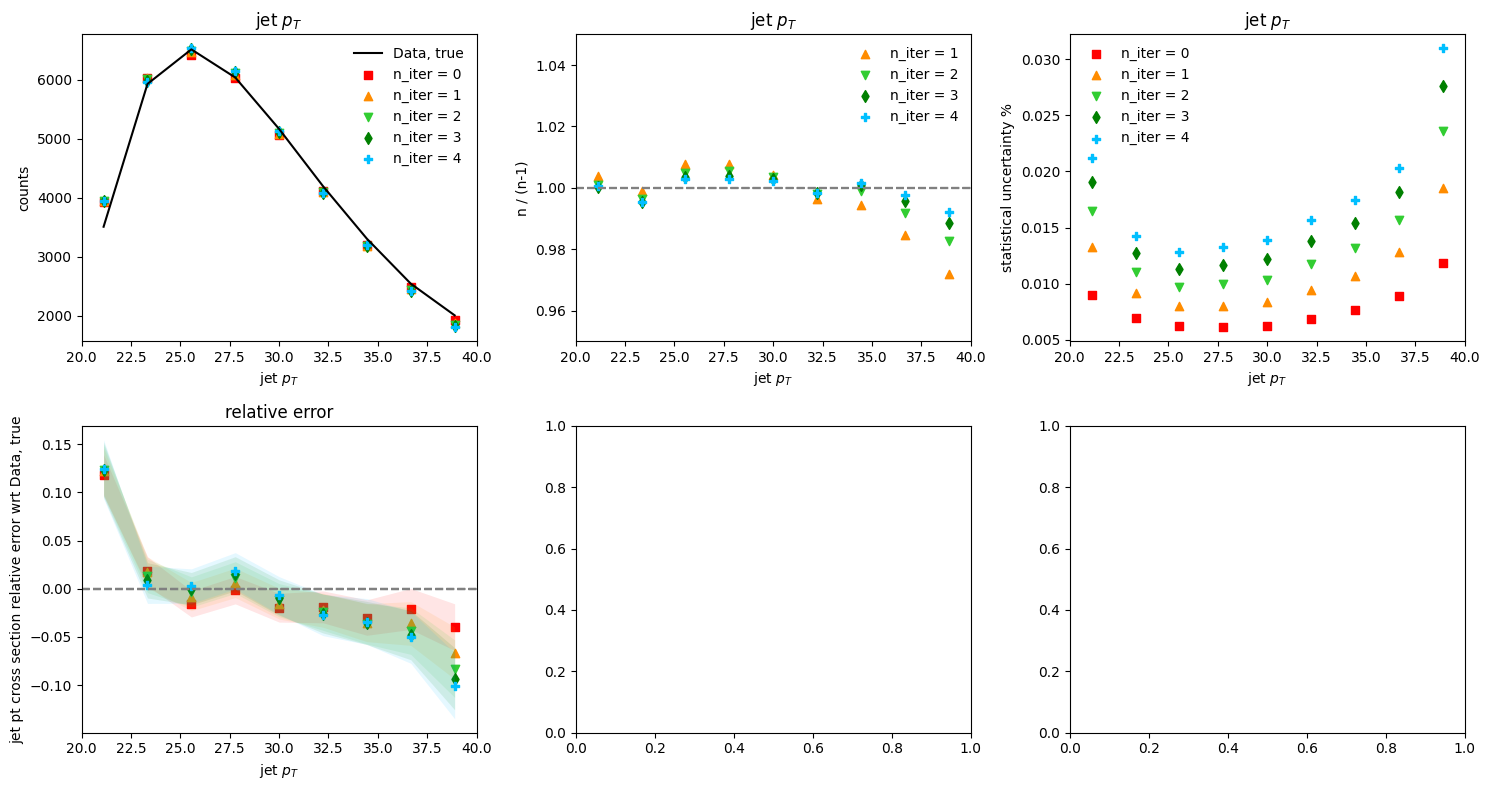

In [8]:
############################## UNFOLDED DISTRIBUTIONS ############################
# EEC distros

it = 5

fig, axes = plt.subplots(2, 3, figsize=(15,8))

pt_lims = [20, 40]

# COL 1: raw jet pt distribution WITH relative error over data, true underneath
ax = axes[0, 0]

ax.plot(bincenters, theta_unknown_G, color='black',label="Data, true")

for iteration in range(it):

    ax.scatter(bincenters, theta_unfolded[iteration],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
    ax.set_ylabel("counts")
    
    ax.set_title(labels)
    ax.set_xlabel(labels)

    ax.legend(frameon=False)

    ax.set_xlim(pt_lims)

# row below with the error

ax = axes[1, 0]

ax.hlines(y=0, xmin=binning[0], xmax=binning[len(binning)-1], color='grey', linestyle='--')

for iteration in range(it):

    yvals, yerrs = get_ratio_safe(theta_unfolded[iteration], theta_unknown_G, \
                                      numerr=theta_unfolded_err[iteration], denomerr=theta_unknown_G_err, filler=1)
    yvals = yvals - 1

    ax.scatter(bincenters, yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.fill_between(bincenters, yvals-yerrs, yvals+yerrs, alpha=0.1, edgecolor=L_colors[iteration], facecolor=L_colors[iteration], linewidth=0)

    ax.hlines(y=0, xmin=binning[0], xmax=binning[len(binning)-1], color='grey', linestyle='--')
    

    ax.set_title("relative error")
    ax.set_xlabel(labels)
    ax.set_ylabel("jet pt cross section relative error wrt Data, true")

    #ax.set_ylim([-0.3, 0.3])
    ax.set_xlim(pt_lims)


# COL 2: convergence plot (n / n - 1)
ax = axes[0, 1]

for iteration in range(1,it):

    yvals = safe_divide(theta_unfolded[iteration], theta_unfolded[iteration-1], filler=1)
    ax.scatter(bincenters, yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.hlines(y=1, xmin=binning[0], xmax=binning[len(binning)-1], color='grey', linestyle='--')

    ax.set_title(labels)
    ax.set_xlabel(labels)
    ax.set_ylabel("n / (n-1)")
    ax.legend(frameon=False)

    ax.set_ylim([0.95, 1.05])
    ax.set_xlim(pt_lims)


# COL 3: statistical error %
ax = axes[0, 2]

for iteration in range(it):
    
    yvals = safe_divide(theta_unfolded_err[iteration], theta_unfolded[iteration])
    ax.scatter(bincenters, yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.set_title(labels)
    ax.set_xlabel(labels)
    ax.set_ylabel("statistical uncertainty %")
    ax.legend(frameon=False)

    ax.set_xlim(pt_lims)


fig.tight_layout()
plt.show()
